# Property regression example

## low level interface

To show how the components of NFFLr work together, let's train a formation energy model using the `dft_3d` dataset.
We can use the `periodic_radius_graph` transform to configure the `AtomsDataset` to automatically transform atomic configurations into `DGLGraph`s.

In [1]:
from nfflr.data.dataset import AtomsDataset
from nfflr.data.graph import periodic_radius_graph
dataset = AtomsDataset(
    "dft_3d", 
    target="formation_energy_peratom", 
    transform=periodic_radius_graph
)
dataset[0]

dataset_name='dft_3d'
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


(Graph(num_nodes=8, num_edges=288,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor(-0.4276))

In [7]:
dataset = AtomsDataset(
    "/Users/bld/projects/nfflr/examples/poscar-folder-bandgap", 
    target="target", 
    transform=periodic_radius_graph
)
dataset[0]

dataset_name='/Users/bld/projects/nfflr/examples/poscar-folder-bandgap'


(Graph(num_nodes=8, num_edges=288,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor(0.))

Set up a medium-sized ALIGNN model:

In [36]:
from nfflr.models.gnn import alignn
cfg = alignn.ALIGNNConfig(
    alignn_layers=2, 
    gcn_layers=2, 
    norm="layernorm", 
    atom_features="embedding"
)
model = alignn.ALIGNN(cfg)

atoms, target = dataset[0]
model(atoms)

tensor(0.2098, grad_fn=<SqueezeBackward0>)

In [31]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler

batchsize = 2

train_loader = DataLoader(
    dataset,
    batch_size=batchsize, 
    collate_fn=dataset.collate, 
    sampler=SubsetRandomSampler(dataset.split["train"]),
    drop_last=True
)
next(iter(train_loader))

(Graph(num_nodes=71, num_edges=1192,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor([2.4720, 0.0000]))

Now we can set up a PyTorch optimizer and objective function and optimize the model parameters with an explicit training loop. See the [PyTorch quickstart tutorial for more context)[https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html].

In [32]:
from tqdm import tqdm
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)

training_loss = []
for epoch in range(5):
    for step, (g, y) in enumerate(tqdm(train_loader)):
        pred = model(g)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        training_loss.append(loss.item())

100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


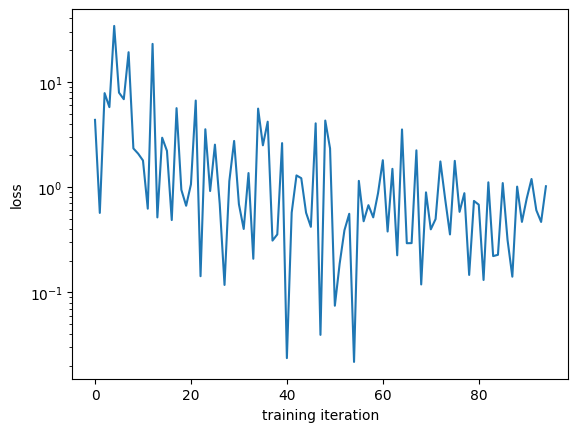

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(training_loss)
plt.xlabel("training iteration")
plt.ylabel("loss");
plt.semilogy();

# using the ignite-based NFFLr trainer

In [34]:
import tempfile
from nfflr import train

In [37]:
rank = 0
training_config = {
    "dataset": dataset,
    "model": model,
    "optimizer": optimizer,
    "criterion": criterion,
    "random_seed": 42,
    "batch_size": 2,
    "learning_rate": 1e-3,
    "weight_decay": 0.1,
    "epochs": 5,
    "warmup_steps": 100,
    "num_workers": 0,
    "progress": True,
    "output_dir": tempfile.TemporaryDirectory().name
}
train.run_train(rank, training_config)

2023-06-08 07:31:34,434 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<nfflr.data.dataset.': 
	{'collate_fn': <function AtomsDataset.collate_default at 0x293eda560>, 'batch_size': 2, 'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x2c9fb2c50>, 'drop_last': True, 'num_workers': 0, 'pin_memory': False}
2023-06-08 07:31:34,434 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<nfflr.data.dataset.': 
	{'collate_fn': <function AtomsDataset.collate_default at 0x293eda560>, 'batch_size': 2, 'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x2c984f790>, 'drop_last': True, 'num_workers': 0, 'pin_memory': False}


starting training loop


train results - Epoch: 1  Avg loss: 0.11


val results - Epoch: 1  Avg loss: 3.52


train results - Epoch: 2  Avg loss: 6.07


val results - Epoch: 2  Avg loss: 3.54


train results - Epoch: 3  Avg loss: 14.54


val results - Epoch: 3  Avg loss: 0.19


train results - Epoch: 4  Avg loss: 0.23


val results - Epoch: 4  Avg loss: 3.54


train results - Epoch: 5  Avg loss: 0.09


val results - Epoch: 5  Avg loss: 3.45


3.4533848762512207

In [38]:
!ls

atoms.ipynb               property-regression.ipynb test.ipynb
